In [1]:
%load_ext autoreload
%autoreload 2

In [94]:
X.shape


(6502, 200, 200, 2)

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from shapely import wkt
import geopandas as gpd
import prepareModel
import rasterio
import rasterio.plot
import plotting
import glob

/Users/giuseppeperonato/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/giuseppeperonato/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/giuseppeperonato/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/giusep

In [3]:
def getErr(predictor, real):
    diff = predictor  - real
    percentDiff = (diff / real) * 100
    absPercentDiff = np.abs(percentDiff)
    return percentDiff, absPercentDiff

In [4]:
def makePoint(tiles_sel):
    tiles_sel['geometry'] = tiles_sel['geometry'].apply(wkt.loads)
    tiles_sel = gpd.GeoDataFrame(tiles_sel)
    tiles_sel['geometry'] = tiles_sel['geometry'].centroid
    tiles_sel.crs = "EPSG:2056"
    return tiles_sel

In [5]:
def makePolygon(tiles_sel):
    tiles_sel['geometry'] = tiles_sel['geometry'].apply(wkt.loads)
    tiles_sel = gpd.GeoDataFrame(tiles_sel)
    tiles_sel['geometry'] = tiles_sel['geometry']
    tiles_sel.crs = "EPSG:2056"
    return tiles_sel

In [6]:
uid = "8561367c-97c3-11eb-b3f9-3e22fb3fc3ab" # context-aware


model = load_model("results/{}/model".format(uid))
with open("results/{}/parameters.json".format(uid), "r") as f:
    parameters = json.loads(f.read())


tiles_sel, X_train, X_val, X_test = prepareModel.getX(parameters)

if parameters["predicting_on_tile100"]:
    parameters["tile_size"] = 100
    
X = np.concatenate([X_train, X_val, X_test])
tiles_sel['geometry'] = tiles_sel['geometry'].apply(wkt.loads)
tiles_sel = gpd.GeoDataFrame(tiles_sel)
tiles_sel['geometry'] = tiles_sel['geometry'].centroid
tiles_sel.crs = "EPSG:2056"


y_test = tiles_sel.loc[:,parameters["predicting_variable"]].values 

tiles_sel["footprint_area_esm"] = (X[:,:,:,0]==0).sum(axis=(1,2))*parameters["pixel_size"]

pred = model.predict(X).flatten()

tiles_sel.loc[:,parameters["predicting_variable"]+"_pred"] =  pred
tiles_sel.loc[:,parameters["predicting_variable"]+"_diff"] =  pred-tiles_sel.loc[:,parameters["predicting_variable"]].values
tiles_sel.loc[:,parameters["predicting_variable"]+"_percentdiff"] =  (tiles_sel.loc[:,parameters["predicting_variable"]+"_diff"].values /
                                                                      tiles_sel.loc[:,parameters["predicting_variable"]].values)*100


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Predicting on tile 100


In [7]:
tiles_sel

,geometry,nIDC,nBLDG,heated_area,footprint_area,idc_norm,idc_norm_foot,idc_abs,idc_coverage_ratio,building_coverage_ratio_raster,building_coverage_ratio_vector,difference_ratio,set,footprint_area_esm,idc_abs_pred,idc_abs_diff,idc_abs_percentdiff
191595,POINT (2506380.352 1118964.157),2.0,5.0,12058.268030,1598.245298,0.196813,1.491954,2384.507694,0.159825,0.536875,0.28000,0.917411,train,11017.5,649.003113,-1735.504581,-72.782511
79858,POINT (2494630.352 1113364.157),8.0,15.0,3006.621471,952.331057,0.138621,0.435460,414.702485,0.095233,0.231875,0.11000,1.107955,train,12207.5,343.363647,-71.338837,-17.202414
115064,POINT (2498330.352 1116164.157),9.0,14.0,11241.237584,2662.791708,0.157066,0.656229,1747.401481,0.266279,0.460000,0.28250,0.628319,train,12467.5,919.642517,-827.758964,-47.370852
102722,POINT (2497030.352 1116564.157),6.0,8.0,12077.145587,1438.413871,0.122318,1.028301,1479.122126,0.143841,0.388750,0.13750,1.827273,train,17327.5,1056.689697,-422.432429,-28.559672
120310,POINT (2498880.352 1117214.157),5.0,8.0,6627.201309,1497.968769,0.288858,1.208325,1810.033251,0.149797,0.257500,0.14000,0.839286,train,9082.5,597.929993,-1212.103258,-66.965801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132200,POINT (2500130.352 1117964.157),3.0,6.0,3105.155437,1001.382346,0.199056,0.568961,569.747852,0.100138,0.060625,0.12250,0.505102,test,11995.0,236.734024,-333.013828,-58.449335
133569,POINT (2500280.352 1115164.157),3.0,3.0,3450.528465,1320.239424,0.123109,0.322460,425.724767,0.132024,0.264375,0.12500,1.115000,test,8077.5,576.888550,151.163783,35.507397
86627,POINT (2495330.352 1119314.157),6.0,13.0,4719.678679,1262.121345,0.135751,0.472253,596.040555,0.126212,0.560000,0.21250,1.635294,test,20752.5,388.827240,-207.213315,-34.764969
176347,POINT (2504780.352 1116564.157),5.0,5.0,4721.110702,2471.463398,0.237756,0.427508,1056.571043,0.247146,0.473750,0.25750,0.839806,test,14725.0,784.260193,-272.310850,-25.773075


# See the sets

In [8]:
tiles_sel.loc[tiles_sel["set"] == "train",:].shape

(14214, 17)

In [9]:
tiles_sel.loc[(tiles_sel["set"] == "train") & ~(tiles_sel.index.str.contains("flip",na=False, regex=True)),:].shape

(4738, 17)

In [10]:
tiles_sel.loc[tiles_sel["set"] == "validation",:].shape

(1579, 17)

In [11]:
tiles_sel.loc[tiles_sel["set"] == "test",:].shape

(1580, 17)

## Results on testing set

In [12]:
test_tiles = tiles_sel.loc[tiles_sel["set"] == "test",:]

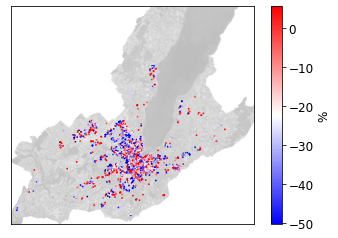

In [13]:
src = rasterio.open("data/SWISSIMAGE25/SI25-2012-2013-2014.tif")
    
fig,ax = plt.subplots()
rasterio.plot.show(src.read(1),transform=src.transform, ax =ax,alpha=0.3,cmap="gray")
# municipalities.plot(ax=ax)
test_tiles.plot(column= parameters["predicting_variable"]+"_percentdiff",s=0.5,ax=ax,legend=True,
                vmin=tiles_sel[parameters["predicting_variable"]+"_percentdiff"].quantile(0.10),
                vmax=tiles_sel[parameters["predicting_variable"]+"_percentdiff"].quantile(0.90),
                cmap="bwr",legend_kwds={"label": "%"})
plt.xticks([])
plt.yticks([])
plt.show()


In [14]:
print("Over-estimated tiles:",
      np.round((test_tiles[parameters["predicting_variable"]+"_percentdiff"] > 0).sum()/test_tiles.shape[0] * 100,2),
      "%")
print("Under-estimated tiles:",
      np.round((test_tiles[parameters["predicting_variable"]+"_percentdiff"] < 0).sum()/test_tiles.shape[0] * 100,2),
      "%")

Over-estimated tiles: 27.03 %
Under-estimated tiles: 72.97 %


In [15]:
print("Mean:", test_tiles[parameters["predicting_variable"]+"_percentdiff"].abs().mean())
print("Median:", test_tiles[parameters["predicting_variable"]+"_percentdiff"].abs().median())
print("STD:", test_tiles[parameters["predicting_variable"]+"_percentdiff"].abs().std())

Mean: 35.554891898092755
Median: 28.36616569252474
STD: 40.57268888272278


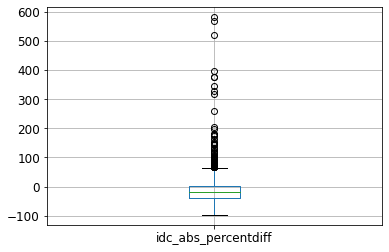

In [16]:
test_tiles.boxplot(parameters["predicting_variable"]+"_percentdiff")
plt.show()

## Per tile analysis


In [17]:
test_tiles = test_tiles.sort_values(parameters["predicting_variable"]+"_percentdiff",ascending=False)

In [18]:
test_tiles_sel = test_tiles.loc[(test_tiles["footprint_area_esm"]/parameters["tile_size"]**2 > 0.1)&
                                (test_tiles["nBLDG"] > 2)&
                                (test_tiles["footprint_area_esm"]/test_tiles["footprint_area"] > 0.8) &
                                (test_tiles["footprint_area_esm"]/test_tiles["footprint_area"] < 1.2)
                                ,:]
test_tiles_sel = test_tiles

In [19]:
print("Mean:", test_tiles_sel[parameters["predicting_variable"]+"_percentdiff"].abs().mean())
print("Median:", test_tiles_sel[parameters["predicting_variable"]+"_percentdiff"].abs().median())
print("STD:", test_tiles_sel[parameters["predicting_variable"]+"_percentdiff"].abs().std())

Mean: 35.554891898092755
Median: 28.36616569252474
STD: 40.57268888272278


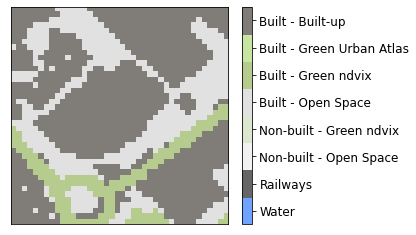

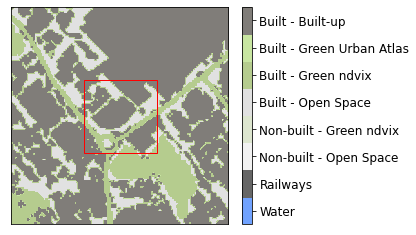

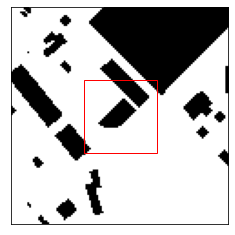

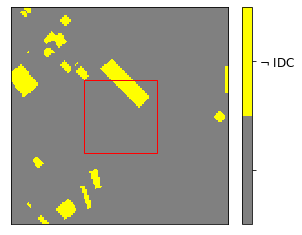

/Users/giuseppeperonato/opt/anaconda3/envs/tf/lib/python3.7/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/Users/giuseppeperonato/opt/anaconda3/envs/tf/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


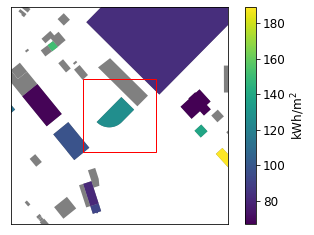

In [20]:
index = 0
plotting.tileshow(test_tiles,
         "esm",
         parameters["grid_type"],
         "contiguous",
         100,
         test_tiles.index[index],
            path="img/tile_{}_esm_100.pdf".format(test_tiles.index[index]))
plotting.tileshow(test_tiles,
         "esm",
         parameters["grid_type"],
         "overlapped",
         300,
         test_tiles.index[index],
            path="img/tile_{}_esm_300.pdf".format(test_tiles.index[index]))
plotting.tileshow(test_tiles,
         "footprints",
         parameters["grid_type"],
         "overlapped",
         300,
         test_tiles.index[index],
            path="img/tile_{}_footprints_300.pdf".format(test_tiles.index[index]))
plotting.tileshow(test_tiles,
         "mask",
         parameters["grid_type"],
         "overlapped",
         300,
         test_tiles.index[index],
        path="img/tile_{}_mask_300.pdf".format(test_tiles.index[index]))
plotting.tileshow(test_tiles,
         "idc",
         parameters["grid_type"],
         "overlapped",
         300,
         test_tiles.index[index],
            path="img/tile_{}_idc_300.pdf".format(test_tiles.index[index]))


In [21]:
print(test_tiles.iloc[index])

geometry                          POINT (2495080.351599999 1119464.157200001)
nIDC                                                                 3.000000
nBLDG                                                                5.000000
heated_area                                                        679.061590
footprint_area                                                    1273.112767
idc_norm                                                             0.120543
idc_norm_foot                                                        0.058902
idc_abs                                                             74.988901
idc_coverage_ratio                                                   0.127311
building_coverage_ratio_raster                                       0.596875
building_coverage_ratio_vector                                       0.228125
difference_ratio                                                     1.616438
set                                                             

In [22]:
idc = gpd.read_file("data/GDB_SCANE_INDICE_MOYENNES_3_ANS/SCANE_INDICE_MOYENNES_3_ANS.gdb")

In [23]:
idc = idc.loc[idc.ANNEE == 2016,:]

In [95]:
idc

,EGID,ADRESSE,NPA,COMMUNE,DESTINATION,NBRE_PRENEUR,AVANT_93,ANNEE,SRE,SRE_416_1,...,AGENT_ENERGETIQUE_2,QUANTITE_AGENT_ENERGETIQUE_2,UNITE_AGENT_ENERGETIQUE_2,AGENT_ENERGETIQUE_3,QUANTITE_AGENT_ENERGETIQUE_3,UNITE_AGENT_ENERGETIQUE_3,SHAPE_Length,SHAPE_Area,geometry,idc
82479,1018196.0,Chemin des Murets 16,1248,Hermance,Hab plusieurs logements,6,Oui,2016,763.0,Oui,...,None,NaN,None,None,NaN,None,75.761414,283.824028,"MULTIPOLYGON (((2508015.666 1128364.854, 25080...",395997.0
82480,2040875.0,Avenue du Curé-BAUD 32,1212,Lancy,Hab plusieurs logements,8,Non,2016,957.6,Oui,...,None,NaN,None,None,NaN,None,68.149820,251.579009,"MULTIPOLYGON (((2498009.429 1115025.095, 24980...",459648.0
82481,3132056.0,Chemin du Curé-DESCLOUDS 6,1226,Thônex,Hab plusieurs logements,22,Non,2016,2216.0,Oui,...,None,NaN,None,None,NaN,None,100.707241,427.950867,"MULTIPOLYGON (((2504380.439 1115864.188, 25043...",886400.0
82482,2042538.0,Rue de la Bergère 42,1217,Satigny,Garage,2,Oui,2016,2446.0,Oui,...,None,NaN,None,None,NaN,None,184.563417,2003.217753,"MULTIPOLYGON (((2493335.484 1120172.395, 24933...",1707308.0
82483,1014026.0,Rue SILLEM 11,1207,Genève-Eaux-Vives,Habitation - activités,45,Oui,2016,3501.0,Oui,...,None,NaN,None,None,NaN,None,90.537429,484.770495,"MULTIPOLYGON (((2501517.709 1117953.870, 25015...",1445913.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99529,1005028.0,Chemin de la Gradelle 22,1224,Chêne-Bougeries,Hab plusieurs logements,22,Oui,2016,2091.0,Oui,...,None,NaN,None,None,NaN,None,75.571469,294.314253,"MULTIPOLYGON (((2503256.204 1117747.900, 25032...",907494.0
99530,1005007.0,Chemin de la Bride 4,1224,Chêne-Bougeries,Hab plusieurs logements,21,Oui,2016,1992.0,Oui,...,None,NaN,None,None,NaN,None,69.717539,297.884798,"MULTIPOLYGON (((2503289.859 1117672.382, 25032...",1039824.0
99531,1005008.0,Chemin de la Bride 6,1224,Chêne-Bougeries,Hab plusieurs logements,19,Oui,2016,1936.0,Oui,...,None,NaN,None,None,NaN,None,75.322029,292.614195,"MULTIPOLYGON (((2503309.825 1117667.040, 25032...",1010592.0
99532,1005010.0,Avenue des Cavaliers 3,1224,Chêne-Bougeries,Hab plusieurs logements,26,Oui,2016,2223.0,Oui,...,None,NaN,None,None,NaN,None,69.859718,299.210130,"MULTIPOLYGON (((2503228.353 1117655.820, 25032...",1160406.0


In [24]:
from shapely.geometry import box
def fromPointToSquare(point, size=100):
    try:
        return box(point.coords[0][0]-size/2,point.coords[0][1]-size/2,point.coords[0][0]+size/2,point.coords[0][1]+size/2)
    except:
        return point

In [25]:
test_tiles.loc[:,"geometry"] = test_tiles.loc[:,"geometry"].apply(fromPointToSquare)

In [26]:
idc.loc[idc.within(test_tiles.loc[test_tiles.index[index],"geometry"]),["DESTINATION","INDICE","SRE","SHAPE_Area"]]

,DESTINATION,INDICE,SRE,SHAPE_Area
83193,Dépôt,456.0,360.0,1070.817938


In [27]:
geometry = test_tiles.loc[test_tiles.index[index],"geometry"]
crossing = (idc.intersects(geometry)&~idc.within(geometry))
idc = idc.copy()
idc.loc[:,"idc"] = idc.INDICE * idc.SRE
try:
    crossing_clipped = gpd.clip(idc.loc[crossing,:],geometry)
except:
    print("Invalid geometry in tile {}".format(i))
    crossing_clipped = gpd.GeoDataFrame(columns=idc.columns)
crossing_clipped["ratio_inside"] = 1-(crossing_clipped["SHAPE_Area"]- crossing_clipped.area) \
/crossing_clipped["SHAPE_Area"]
intile = idc.intersects(geometry)
idc_mod  = idc.loc[intile,:].copy()
# Weighting this buildings by their footprint area within the tile
idc_mod.loc[crossing,["SHAPE_Area","SRE","INDICE","idc"]] = \
    idc_mod.loc[crossing,["SHAPE_Area","SRE","INDICE","idc"]].multiply(
        crossing_clipped["ratio_inside"],axis=0)

In [28]:
idc_mod["idc"].sum()/3600 # MWH

74.98890057704953

In [29]:
idc_mod[["SHAPE_Area","SRE"]]

,SHAPE_Area,SRE
83193,1070.817938,360.000000
86041,72.160964,198.512744
86237,130.133865,120.548846


## Check excluded tiles

In [30]:
parameters_new = parameters.copy()
parameters_new["difference_ratio"] = 2

In [31]:
if parameters_new != parameters:
    tiles_np, X_train_np, X_val_np, X_test_np = prepareModel.getX(parameters_new)
else:
    tiles_np = tiles_sel.copy()

In [32]:
parameters_non_excluded = parameters.copy()
parameters_non_excluded["idc_coverage_ratio"] = 0
parameters_non_excluded["flipping_xy"] = True
parameters_non_excluded["difference_ratio"] = 999

In [33]:
parameters_non_excluded

{'tile_size': 100,
 'pixel_size': 2.5,
 'grid_type': 'grid50',
 'tile_type': 'overlapped',
 'ratio_with_idc': 0.4,
 'idc_coverage_ratio': 0,
 'difference_ratio': 999,
 'predicting_variable': 'idc_abs',
 'predicting_on_tile100': True,
 'flipping': False,
 'flipping_xy': True,
 'use_heights': False,
 'modeled_height': False,
 'training_ratio': 0.6,
 'validation_ratio': 0.2,
 'context_aware': True}

In [34]:
parameters_new

{'tile_size': 100,
 'pixel_size': 2.5,
 'grid_type': 'grid50',
 'tile_type': 'overlapped',
 'ratio_with_idc': 0.4,
 'idc_coverage_ratio': 0.05,
 'difference_ratio': 2,
 'predicting_variable': 'idc_abs',
 'predicting_on_tile100': True,
 'flipping': False,
 'flipping_xy': True,
 'use_heights': False,
 'modeled_height': False,
 'training_ratio': 0.6,
 'validation_ratio': 0.2,
 'context_aware': True}

In [35]:
tiles_ne, X_train_ne, X_val_ne, X_test_ne = prepareModel.getX(parameters_non_excluded)

Predicting on tile 100


In [36]:
tiles_ne.shape

(25454, 13)

In [37]:
tiles_np.shape

(17373, 17)

In [38]:
tiles_np.groupby("set").count()

,geometry,nIDC,nBLDG,heated_area,footprint_area,idc_norm,idc_norm_foot,idc_abs,idc_coverage_ratio,building_coverage_ratio_raster,building_coverage_ratio_vector,difference_ratio,footprint_area_esm,idc_abs_pred,idc_abs_diff,idc_abs_percentdiff
set,,,,,,,,,,,,,,,,
test,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580,1580
train,14214,14214,14214,14214,14214,14214,14214,14214,14214,14214,14214,14214,14214,14214,14214,14214
validation,1579,1579,1579,1579,1579,1579,1579,1579,1579,1579,1579,1579,1579,1579,1579,1579


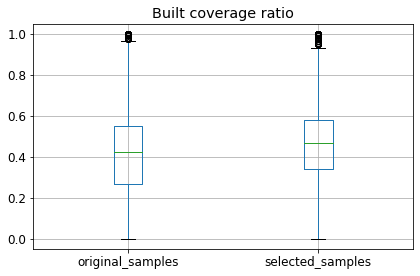

original_samples    0.421875
selected_samples    0.465000
dtype: float64

In [39]:
comparison = pd.DataFrame()
comparison["original_samples"] = tiles_ne["building_coverage_ratio_raster"]
comparison["selected_samples"] = tiles_np["building_coverage_ratio_raster"]
comparison.boxplot()
plt.title("Built coverage ratio")
plt.tight_layout()
plt.savefig("img/filtering.pdf")
plt.show()
comparison.median()

In [40]:
comparison

,original_samples,selected_samples
149489,0.170625,0.170625
140708,0.485000,0.485000
116576,0.530000,0.539375
118014,0.415625,0.415625
147829,0.038750,NaN
...,...,...
192676,0.294375,NaN
119395,0.209375,0.209375
119819,0.401875,0.401875
76660,0.403750,NaN


In [41]:
tiles_noflip = tiles_np.copy()
tiles_noflip = tiles_noflip.loc[~tiles_noflip.index.str.contains(pat = 'flip',na=False),:]

In [42]:
tiles_noflip.shape

(7897, 17)

In [43]:
tiles_excluded = tiles_ne.copy()
tiles_excluded = tiles_excluded.drop(tiles_excluded.index[tiles_excluded.index.isin(tiles_noflip.index)])

In [46]:
tiles_excluded.shape

(17557, 13)

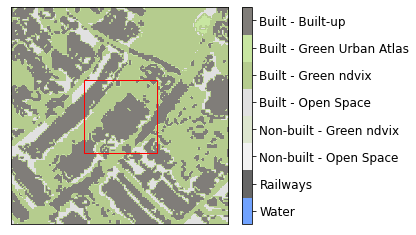

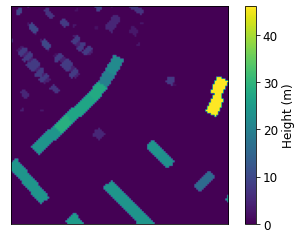

geometry                          POLYGON ((2497880.351599999 1114564.157200001,...
nIDC                                                                       4.000000
nBLDG                                                                      5.000000
heated_area                                                             7079.637753
footprint_area                                                           893.539137
idc_norm                                                                   0.119124
idc_norm_foot                                                              0.941897
idc_abs                                                                  841.621458
idc_coverage_ratio                                                         0.089354
building_coverage_ratio_raster                                             0.501250
building_coverage_ratio_vector                                             0.110000
difference_ratio                                                           3

In [47]:
index = 5
plotting.tileshow(tiles_excluded,
         "esm",
         parameters["grid_type"],
         "overlapped",
         300,
         tiles_excluded.index[index])
plotting.tileshow(tiles_excluded,
         "height",
         parameters["grid_type"],
         "overlapped",
         300,
         tiles_excluded.index[index])
print(tiles_excluded.iloc[index])

## Comparison with HotMaps

In [48]:
hotmaps = pd.read_csv("data/hotmaps_heat_density.csv",index_col=0)

In [49]:
hotmaps_tiles = pd.read_csv("data/hotmaps_100_contiguous.csv",index_col=0)

In [50]:
hotmaps_tiles = hotmaps_tiles.loc[hotmaps_tiles["idc_abs"] != 0,:]

In [51]:
hotmaps = pd.merge(hotmaps_tiles,hotmaps,how="left",
                   left_index=True,right_index=True,
                   suffixes=("_geneva","_hotmaps"))

# Correct hotmaps heat density considering by floor area
hotmaps["idc_abs_hotmaps_corr"] = hotmaps["idc_abs_hotmaps"] * \
                                 (hotmaps["heated_area_geneva"]/hotmaps["heated_area_hotmaps"])


In [52]:
hotmaps["geometry"] = hotmaps["geometry_hotmaps"]
hotmaps = makePoint(hotmaps)

In [53]:
params_hotmaps = {'tile_size': 300,
                 'pixel_size': 2.5,
                 'grid_type': 'hotmaps',
                 'tile_type': 'overlapped',
                 'ratio_with_idc': 0.4,
                 'idc_coverage_ratio': 0.05,
                 "difference_ratio": 0.8,
                 'predicting_variable': 'idc_abs',
                 'predicting_on_tile100': True,
                 'flipping': False,
                 'flipping_xy': False,
                 'use_heights': False,
                 'modeled_height': False,
                 'training_ratio': 0.6,
                 'validation_ratio': 0.2}

In [54]:
tiles_sel_HM, X_train_HM, X_val_HM, X_test_HM = prepareModel.getX(params_hotmaps)

Predicting on tile 100


In [55]:
X_HM = np.concatenate([X_train_HM, X_val_HM, X_test_HM])
pred_X_HM = model.predict(X_HM).flatten()
tiles_sel_HM["idc_abs_pred"] = pred_X_HM

In [56]:
tiles_sel_HM.shape

(891, 14)

In [57]:
hotmaps.shape

(4474, 13)

In [58]:
common_idx = np.intersect1d(tiles_sel_HM.index,hotmaps.index)

In [59]:
hotmaps.loc[common_idx,"idc_abs_modeled"] = tiles_sel_HM.loc[common_idx,"idc_abs_pred"]

In [60]:
predictor = hotmaps.loc[common_idx,"idc_abs_hotmaps_corr"]
real = hotmaps.loc[common_idx,"idc_abs_geneva"]
HM_percentDiff, HM_absPercentDiff = getErr(predictor,real)
hotmaps.loc[common_idx,"percentDiff_HM"] = HM_percentDiff

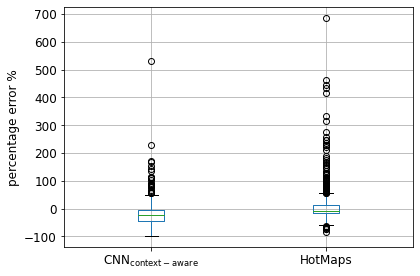

Median
 CNN        28.087496
HotMaps    15.819756
dtype: float64 

Mean
 CNN        33.727592
HotMaps    28.440973
dtype: float64 

STD
 CNN        30.501818
HotMaps    50.908927
dtype: float64 



In [61]:
predictor = hotmaps.loc[common_idx,"idc_abs_modeled"]
real = hotmaps.loc[common_idx,"idc_abs_geneva"]
CNN_percentDiff, CNN_absPercentDiff = getErr(predictor,real)
hotmaps.loc[common_idx,"percentDiff_CNN"] = CNN_percentDiff

percentDiff = pd.DataFrame(pd.DataFrame([CNN_percentDiff,HM_percentDiff],index=["CNN$_{\mathrm{context-aware}}$","HotMaps"])).transpose()
absPercentDiff = pd.DataFrame(pd.DataFrame([CNN_absPercentDiff,HM_absPercentDiff],index=["CNN","HotMaps"])).transpose()

percentDiff.boxplot()
plt.ylabel("percentage error %")
plt.tight_layout()
plt.savefig("img/boxplot.pdf")
plt.show()

print("Median\n",absPercentDiff.median(),"\n")
print("Mean\n",absPercentDiff.mean(),"\n")
print("STD\n",absPercentDiff.std(),"\n")



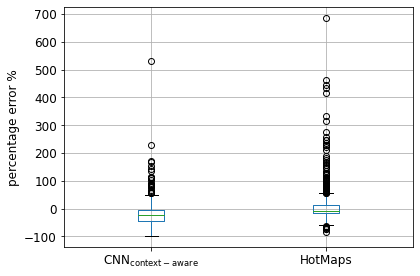

Median
 CNN        28.087496
HotMaps    15.819756
dtype: float64 

Mean
 CNN        33.727592
HotMaps    28.440973
dtype: float64 

STD
 CNN        30.501818
HotMaps    50.908927
dtype: float64 



In [62]:
predictor = hotmaps.loc[common_idx,"idc_abs_modeled"]
real = hotmaps.loc[common_idx,"idc_abs_geneva"]
CNN_percentDiff, CNN_absPercentDiff = getErr(predictor,real)
hotmaps.loc[common_idx,"percentDiff_CNN"] = CNN_percentDiff

percentDiff = pd.DataFrame(pd.DataFrame([CNN_percentDiff,HM_percentDiff],index=["CNN$_{\mathrm{context-aware}}$","HotMaps"])).transpose()
absPercentDiff = pd.DataFrame(pd.DataFrame([CNN_absPercentDiff,HM_absPercentDiff],index=["CNN","HotMaps"])).transpose()

percentDiff.boxplot()
plt.ylabel("percentage error %")
plt.tight_layout()
plt.savefig("img/boxplot.pdf")
plt.show()

print("Median\n",absPercentDiff.median(),"\n")
print("Mean\n",absPercentDiff.mean(),"\n")
print("STD\n",absPercentDiff.std(),"\n")




In [63]:
hotmaps_sorted = hotmaps.sort_values("percentDiff_CNN",ascending=False)

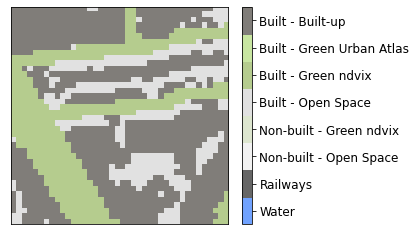

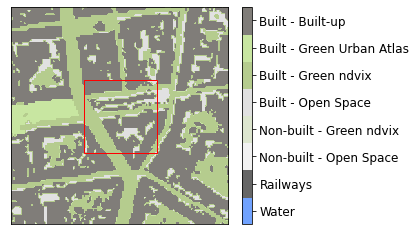

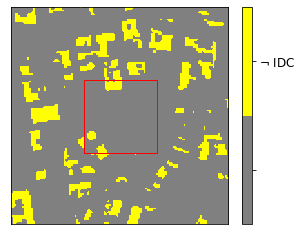

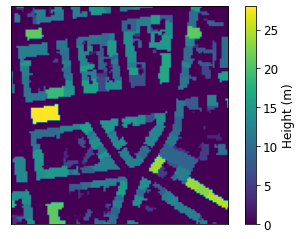

geometry_geneva         POLYGON ((2499871.253950973 1115508.220511522,...
nIDC                                                            19.000000
nBLDG                                                           34.000000
heated_area_geneva                                            9071.915658
footprint_area                                                2751.397397
idc_norm                                                         0.157680
idc_norm_foot                                                    0.511896
idc_abs_geneva                                                1408.430547
idc_abs_hotmaps                                               1368.054698
heated_area_hotmaps                                          11680.418945
geometry_hotmaps              POINT (2499821.253950973 1115558.220511522)
idc_abs_hotmaps_corr                                          1062.536960
geometry                      POINT (2499821.253950973 1115558.220511522)
idc_abs_modeled                       

In [64]:
index = 100
plotting.tileshow(hotmaps_sorted,
         "esm",
         "hotmaps",
         "contiguous",
         100,
         hotmaps_sorted.index[index])
plotting.tileshow(hotmaps_sorted,
         "esm",
         "hotmaps",
         "overlapped",
         300,
         hotmaps_sorted.index[index])
plotting.tileshow(hotmaps_sorted,
         "mask",
         "hotmaps",
         "overlapped",
         300,
         hotmaps_sorted.index[index])
plotting.tileshow(hotmaps_sorted,
         "height",
         "hotmaps",
         "overlapped",
         300,
         hotmaps_sorted.index[index])
print(hotmaps_sorted.iloc[index])

In [65]:
hotmaps_sorted

,geometry_geneva,nIDC,nBLDG,heated_area_geneva,footprint_area,idc_norm,idc_norm_foot,idc_abs_geneva,idc_abs_hotmaps,heated_area_hotmaps,geometry_hotmaps,idc_abs_hotmaps_corr,geometry,idc_abs_modeled,percentDiff_HM,percentDiff_CNN
36823,"POLYGON ((2493865.760898833 1119334.591067609,...",1.0,1.0,1223.883890,7760.625526,0.055833,0.008805,68.333517,532.742699,3861.241211,POINT (2493815.760898833 1119384.591067609),168.861558,POINT (2493815.761 1119384.591),430.658997,147.113810,530.230982
47667,"POLYGON ((2499042.910081712 1114991.143409348,...",2.0,5.0,1038.104419,5179.894305,0.143946,0.027538,142.645694,632.830697,5073.930664,POINT (2498992.910081712 1115041.143409348),129.474442,POINT (2498992.910 1115041.143),468.884491,-9.233543,228.705675
49962,"POLYGON ((2497179.136375876 1114060.404625435,...",1.0,1.0,2364.933520,2052.743515,0.048611,0.056004,114.962046,205.692148,1635.795776,POINT (2497129.136375876 1114110.404625435),297.377132,POINT (2497129.136 1114110.405),310.713562,158.674182,170.274906
36055,"POLYGON ((2494176.389849806 1119644.837328913,...",1.0,2.0,1112.192970,7210.586586,0.155556,0.023994,173.007795,924.772097,5747.916992,POINT (2494126.389849806 1119694.837328913),178.938740,POINT (2494126.390 1119694.837),460.220734,3.428137,166.011559
34262,"POLYGON ((2494797.647751751 1120368.745271956,...",1.0,1.0,9935.250039,4250.284594,0.015556,0.036362,154.548334,1439.932993,11768.231445,POINT (2494747.647751751 1120418.745271956),1215.653719,POINT (2494747.648 1120418.745),392.470673,686.584810,153.946880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57692,"POLYGON ((2499249.996049027 1110957.942012391,...",3.0,23.0,1179.400812,454.124797,0.172055,0.373019,169.396993,172.826120,1432.307983,POINT (2499199.996049027 1111007.942012391),142.309663,POINT (2499199.996 1111007.942),NaN,NaN,NaN
57828,"POLYGON ((2486721.295026459 1110854.526591957,...",1.0,2.0,479.972628,138.186645,0.139444,0.484341,66.929516,26.350561,290.363647,POINT (2486671.295026459 1110904.526591957),43.557615,POINT (2486671.295 1110904.527),NaN,NaN,NaN
57878,"POLYGON ((2491898.444209339 1110854.526591957,...",2.0,14.0,419.000000,161.239601,0.095539,0.248686,40.098056,168.498755,1917.146484,POINT (2491848.444209339 1110904.526591957),36.826074,POINT (2491848.444 1110904.527),NaN,NaN,NaN
57879,"POLYGON ((2492001.987192996 1110854.526591957,...",1.0,14.0,184.000000,69.161298,0.076389,0.203229,14.055556,107.616828,1446.812988,POINT (2491951.987192996 1110904.526591957),13.686286,POINT (2491951.987 1110904.527),NaN,NaN,NaN


(0.0, 4000.0)

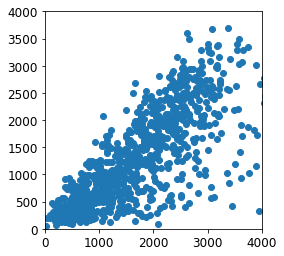

In [66]:
plt.scatter(hotmaps.loc[common_idx,"idc_abs_hotmaps_corr"],
            hotmaps.loc[common_idx,"idc_abs_modeled"])
ax = plt.gca()
ax.set_aspect('equal')
plt.xlim(0,4000)
plt.ylim(0,4000)

# Predict

In [67]:
uid = "c9a8bcd0-96f9-11eb-b3f9-3e22fb3fc3ab"
model_300 = load_model("results/{}/model".format(uid))
parameters_300 = {'tile_size': 300,
                 'pixel_size': 2.5,
                 'grid_type': 'statbl',
                 'tile_type': 'contiguous',
                 'ratio_with_idc': 0,
                 'idc_coverage_ratio': 0,
                 'difference_ratio': 999,
                 'predicting_variable': 'idc_abs',
                 'predicting_on_tile100': False,
                 'flipping': False,
                 'flipping_xy': False,
                 'use_heights': False,
                 'modeled_height': False,
                 'training_ratio': 0.6,
                 'validation_ratio': 0.2}
tiles_300, X_train_300, X_val_300, X_test_300 = prepareModel.getX(parameters_300)
tiles_300 = makePolygon(tiles_300)

In [68]:
X_300 = np.concatenate([X_train_300, X_val_300, X_test_300])

In [69]:
X_300[:,:,:,1] = 0

In [70]:
tiles_300["idc_abs_pred"] = model_300.predict(X_300).flatten() /1000 # MWh to TWh

In [71]:
tiles_300["idc_ha_pred"] = model_300.predict(X_300).flatten() / 9 # MWh to MWh/ha

In [72]:
lims = [2495000,1115000,2503000,1120000]

In [74]:
cad = gpd.read_file("/Users/giuseppeperonato/dev/HeatLearn/data/GDB_CTSS_CHAUFFAGE_CONDUITE/CTSS_CHAUFFAGE_CONDUITE.gdb")

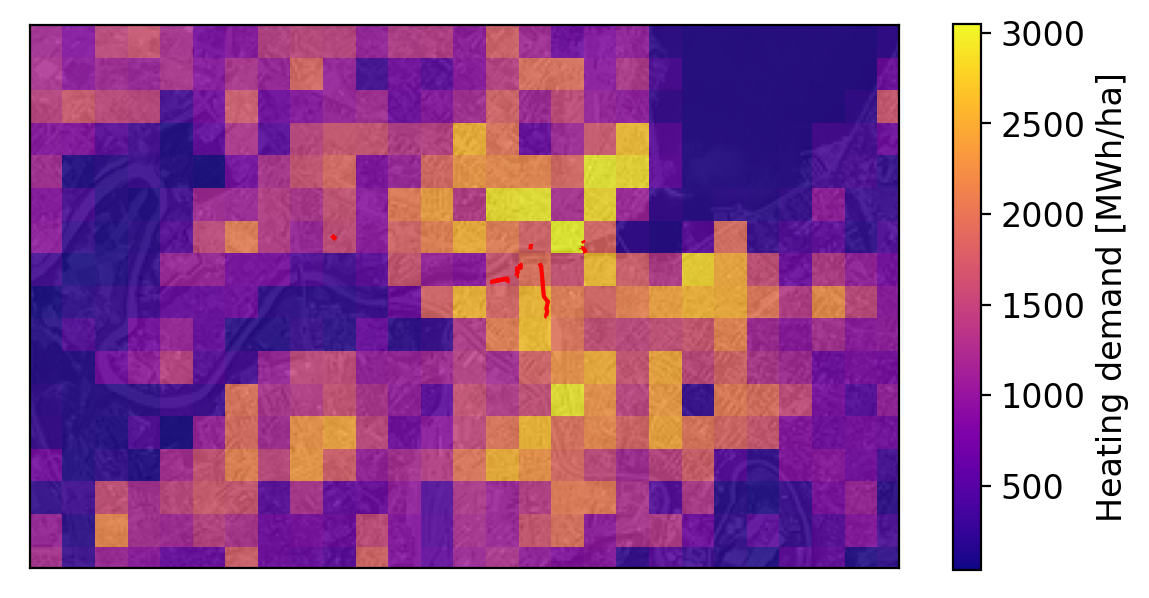

In [75]:
fig,ax = plt.subplots(dpi=200)
rasterio.plot.show(src.read(1),transform=src.transform, ax =ax,alpha=1.0,cmap="gray")
cad.loc[cad.FLUIDE == "Eau surchauffée",:].plot(ax=ax,color="red")
tiles_300.plot(column="idc_ha_pred",legend=True,ax=ax,
               alpha=0.8,
                                                    legend_kwds={"label": "Heating demand [MWh/ha]",
                                                                 "orientation":'vertical',
                                                                 'shrink': 0.75,
                                                                 "pad": 0.05},
                                                                cmap="plasma")
plt.xticks([])
plt.yticks([])
plt.xlim([2495000,2503000])
plt.ylim([1115000,1120000])
plt.tight_layout()
plt.savefig("img/prediction.pdf")
plt.show()

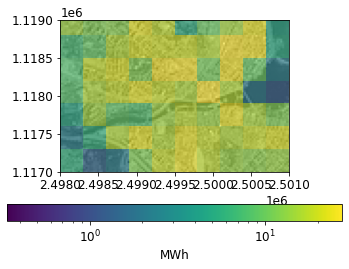

In [76]:
fig,ax = plt.subplots()
tiles_300.plot(column="idc_abs_pred",legend=True,ax=ax,
               alpha=0.6,
                norm=colors.LogNorm(vmin=tiles_300.idc_abs_pred.min(),
                                     vmax=tiles_300.idc_abs_pred.max()),
                legend_kwds={"label": "MWh", "orientation":'horizontal'})
rasterio.plot.show(src.read(1),transform=src.transform, ax =ax,alpha=0.9,cmap="gray")
plt.xlim([2498000,2501000])
plt.ylim([1117000,1119000])
plt.show()

In [77]:
volume = []
floor_area = []
for i, row in tiles_300.iterrows():
    heights = plt.imread("data/GML_CAD_BATIMENT_HORSOL/tiles_statbl_contiguous/tiles_300/{}.tif".format(i))
    volume.append(heights.sum() * 2.5**2)
    floor_area.append((heights/3).sum() * 2.5**2)

In [78]:
tiles_300["built_volume"] = volume

In [79]:
tiles_300["idc_abs_pred_per_built_volume"] = (tiles_300["idc_abs_pred"]/tiles_300["built_volume"]) * 1000

In [80]:
tiles_300["idc_abs_pred_per_built_volume"] = (tiles_300["idc_abs_pred"]/tiles_300["built_volume"]) * 1000

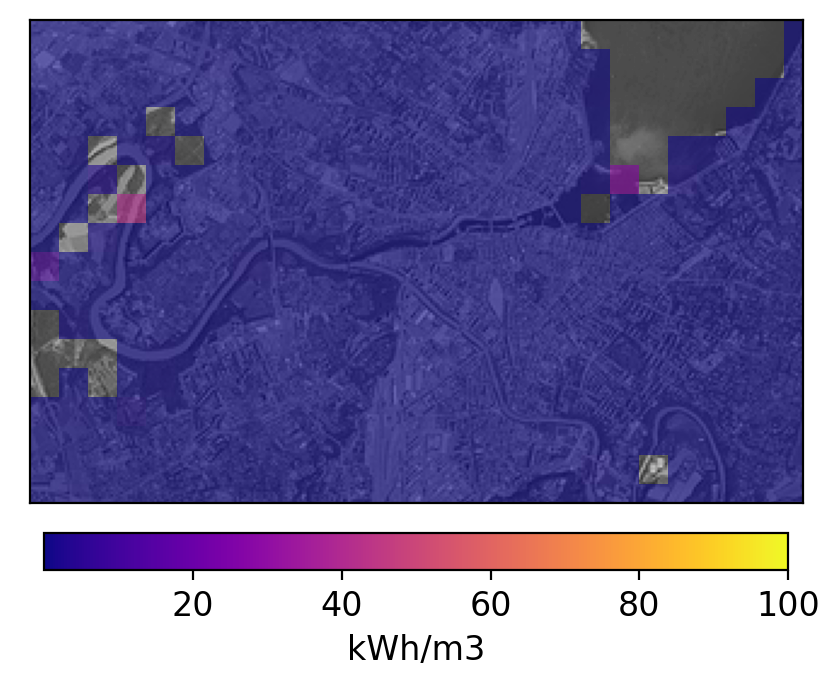

In [81]:
fig,ax = plt.subplots(dpi=200)
tiles_300.loc[(tiles_300["built_volume"] > 0) & (tiles_300.intersects(box(*lims))),:].plot(
                                                    column="idc_abs_pred_per_built_volume",
                                                    legend=True,ax=ax,
                                                    alpha=0.6,
                                                    vmax=100,
                                                    legend_kwds={"label": "kWh/m3",
                                                                 "orientation":'horizontal',
                                                                 'shrink': 0.8,
                                                                 "pad": 0.05},
                                                                cmap="plasma")
rasterio.plot.show(src.read(1),transform=src.transform, ax =ax,alpha=0.9,cmap="gray")
plt.xlim([lims[0],lims[2]])
plt.ylim([lims[1],lims[3]])
plt.xticks([])
plt.yticks([])
plt.show()

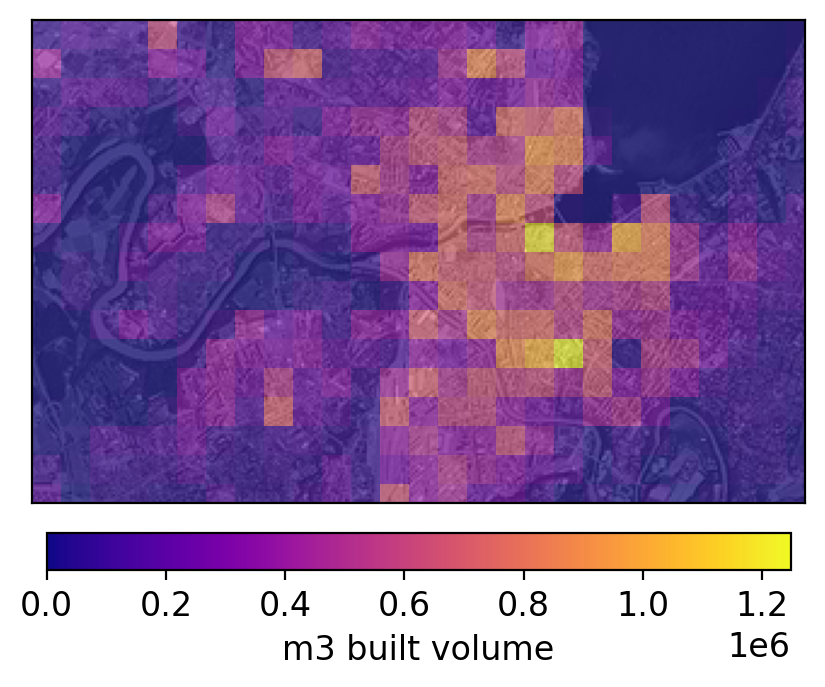

In [82]:
fig,ax = plt.subplots(dpi=200)
tiles_300.loc[tiles_300.intersects(box(*lims))].plot(column="built_volume",
                                                     legend=True,ax=ax,
                                                     alpha=0.6,
                                                    legend_kwds={"label": "m3 built volume",
                                                                 "orientation":'horizontal',
                                                                 'shrink': 0.8,
                                                                 "pad": 0.05},
                                                                cmap="plasma")
rasterio.plot.show(src.read(1),transform=src.transform, ax=ax,alpha=0.9,cmap="gray")
plt.xlim([lims[0],lims[2]])
plt.ylim([lims[1],lims[3]])
plt.xticks([])
plt.yticks([])
plt.show()

# Influence of resolution

In [83]:
parameters_tiles = {
        "tile_size": 100,
        "pixel_size": 2.5,
        "grid_type": "grid50",
        "tile_type": "overlapped",
        "ratio_with_idc": 0.4,
        "idc_coverage_ratio": 0.05,
        "difference_ratio": 0.8,
        "predicting_variable": "idc_abs",
        "predicting_on_tile100": False,
        "flipping": False,
        "flipping_xy": True,
        "use_heights": False,
        "modeled_height": False,
        "training_ratio": 0.6,
        "validation_ratio": 0.2
    }
tiles = []
for size in [100,300,500]:
    parameters_tiles["tile_size"] = size
    for par_file in glob.glob("results/*/*.json"):
        with open(par_file,"r") as f:
            pars = json.loads(f.read())
            if pars == parameters_tiles:
                uid = par_file.split("/")[1]
                model = load_model("results/{}/model".format(uid))
                tiles_sel, X_train, X_val, X_test = prepareModel.getX(parameters_tiles)
                X = np.concatenate([X_train, X_val, X_test])
                tiles_sel["idc_pred"] = model.predict(X).flatten()
                tiles.append([tiles_sel, X_train, X_val, X_test])

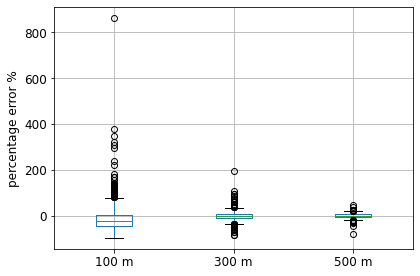

Median
 100 m    34.7
300 m     9.4
500 m     5.2
dtype: float64 

Mean
 100 m    42.4
300 m    13.4
500 m     6.6
dtype: float64 

STD
 100 m    49.3
300 m    16.1
500 m     6.6
dtype: float64 



In [84]:
percentDiff = pd.DataFrame()
absPercentDiff = pd.DataFrame()
for t,tile in enumerate([100,300,500]):
    predictor = tiles[t][0].loc[tiles[t][0]["set"] == "test","idc_pred"]
    real = tiles[t][0].loc[tiles[t][0]["set"] == "test","idc_abs"]
    per, absper = getErr(predictor,real)
    percentDiff = pd.concat([percentDiff,per],axis=1)
    absPercentDiff = pd.concat([absPercentDiff,absper],axis=1)
percentDiff.columns = ["100 m","300 m","500 m"]
absPercentDiff.columns = ["100 m","300 m","500 m"]

percentDiff.boxplot()
plt.ylabel("percentage error %")
plt.tight_layout()
plt.savefig("img/boxplot_resolution.pdf")
plt.show()

print("Median\n",absPercentDiff.median().round(1),"\n")
print("Mean\n",absPercentDiff.round(1).mean().round(1),"\n")
print("STD\n",absPercentDiff.round(1).std().round(1),"\n")

# Linear Model for tile 300

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

In [86]:
def getSummary(tiles, X_train, X_val, X_test):
    y_train = tiles.loc[tiles.set=="train",parameters["predicting_variable"]].values 
    y_val = tiles.loc[tiles.set=="validation",parameters["predicting_variable"]].values 
    y_test = tiles.loc[tiles.set=="test",parameters["predicting_variable"]].values 
    vals = [0/7.,   1/7.,  2/7.,  3/7.,  4/7.,  5/7.,  6/7., 7/7., np.nan]
    X_images = np.concatenate([X_train,X_val,X_test])
    sets = [len(X_train),len(X_val),len(X_test)]
    X_summary = np.zeros([tiles.shape[0], len(vals)])
    for i in range(X_summary.shape[0]):
        X_summary[i,:] = [np.count_nonzero(X_images[i,:,:,0] == v) for v in vals]
        X_summary[i,-1] = np.count_nonzero(X_images[i,:,:,1])
    X_summary_train = X_summary[:sets[0],:]
    X_summary_val = X_summary[sets[0]:sets[0]+sets[1],:]
    X_summary_test = X_summary[-sets[2]:,:]
    return X_summary_train, X_summary_val, X_summary_test

In [87]:
X_summary_train, X_summary_val, X_summary_test = getSummary(*tiles[1])

In [88]:
X_summary = np.concatenate([X_summary_train, X_summary_val, X_summary_test])

In [89]:
poly = PolynomialFeatures(5)
X_train_poly = poly.fit_transform(X_summary_train)
X_test_poly = poly.transform(X_summary_test)
X_summary_poly = poly.transform(X_summary)

In [90]:
ls = LassoCV().fit(X_train_poly, tiles[1][0].loc[tiles[1][0]["set"] == "train","idc_abs"])
tiles[1][0]["idc_pred_linear"] = ls.predict(X_summary_poly).clip(0)

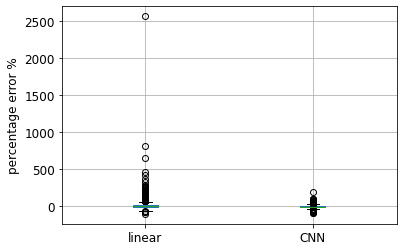

Median
 linear    14.3
CNN        9.4
dtype: float64 

Mean
 linear    37.2
CNN       13.4
dtype: float64 

STD
 linear    122.4
CNN        16.1
dtype: float64 



In [92]:
percentDiff = pd.DataFrame()
absPercentDiff = pd.DataFrame()
model_types = ["linear", "CNN"]
for i,column in enumerate(["idc_pred_linear","idc_pred"]):
    predictor = tiles[1][0].loc[tiles[1][0]["set"] == "test",column]
    real = tiles[1][0].loc[tiles[1][0]["set"] == "test","idc_abs"]
    percentDiff[model_types[i]], absPercentDiff[model_types[i]] = getErr(predictor,real)

percentDiff.boxplot()
plt.ylabel("percentage error %")
plt.savefig("img/boxplot_linear.pdf")
plt.show()

print("Median\n",absPercentDiff.median().round(1),"\n")
print("Mean\n",absPercentDiff.round(1).mean().round(1),"\n")
print("STD\n",absPercentDiff.round(1).std().round(1),"\n")